## Imports

In [81]:
# Begin by importing libraries
import gym
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning

import numpy as np
import pandas as pd
import seaborn as sns
import time

pd.options.mode.chained_assignment = None

np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [82]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def generate_score(env, policy, printInfo=False, episodes=1000):
    misses, steps_list = 0, []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps =steps+1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses =misses + 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
  
    return ave_steps, std_steps, pct_fail

In [83]:
colors, labels = {0: 'green',1: 'k'}, {0: 'W',1: 'C'}

def plot_forest(policy, title='Forest Management'):
    rows,cols = 15,15
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(15):
        for j in range(15):
            y = 15 - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')

# Setup Problem

In [84]:
T,R = hiive.mdptoolbox.example.forest(S=225)

# Value Iteration
## Function

In [89]:
def valueIteration(t, r, gammas, epsilons, show_results=False, max_iterations=100000):
    t0 = time.time()
    
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    df = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            df['gamma'][testNum]        = g
            df['epsilon'][testNum]      = e
            df['time'][testNum]         = Time
            df['iterations'][testNum]   = iters
            df['reward'][testNum]       = maxR
            df['mean_rewards'][testNum] = {tuple(mean_rewards)}
            df['max_rewards'][testNum]  = {tuple(max_rewards)}
            df['error'][testNum]        = np.mean(errors)
            df['policy'][testNum]       = {test.policy}
            
            testNum = testNum + 1
        
    endTime = time.time() - t0
    
    policies = df['policy']
    
    df = df.fillna(0)
    df.head()
        
    return df

## Setup

In [90]:
epsilons = [1e-2, 1e-3, 1e-4, 1e-5, 1e-8, 1e-10, 1e-11, 1e-12]
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
vi_res  = valueIteration(T, R, gammas, epsilons, show_results=False)

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.00,	2,	4.360000
0.10,	1E-03,	0.00,	3,	4.393300
0.10,	1E-04,	0.00,	4,	4.396306
0.10,	1E-05,	0.00,	5,	4.396585
0.10,	1E-08,	0.00,	8,	4.396613
0.10,	1E-10,	0.00,	10,	4.396613
0.10,	1E-11,	0.01,	11,	4.396613
0.10,	1E-12,	0.00,	12,	4.396613
0.20,	1E-02,	0.00,	3,	4.853200
0.20,	1E-03,	0.00,	5,	4.881708
0.20,	1E-04,	0.00,	6,	4.882516
0.20,	1E-05,	0.00,	7,	4.882666
0.20,	1E-08,	0.00,	11,	4.882699
0.20,	1E-10,	0.00,	14,	4.882699
0.20,	1E-11,	0.00,	15,	4.882699
0.20,	1E-12,	0.00,	17,	4.882699
0.30,	1E-02,	0.00,	4,	5.460862
0.30,	1E-03,	0.00,	6,	5.489575
0.30,	1E-04,	0.00,	8,	5.491753
0.30,	1E-05,	0.00,	10,	5.491919
0.30,	1E-08,	0.00,	15,	5.491933
0.30,	1E-10,	0.00,	18,	5.491933
0.30,	1E-11,	0.00,	20,	5.491933
0.30,	1E-12,	0.00,	22,	5.491933
0.40,	1E-02,	0.00,	6,	6.262393
0.40,	1E-03,	0.00,	8,	6.275508
0.40,	1E-04,	0.00,	10,	6.277290
0.40,	1E-05,	0.01,	13,	6.277559
0.40,	

In [91]:
policies = vi_res['policy']

## Plots

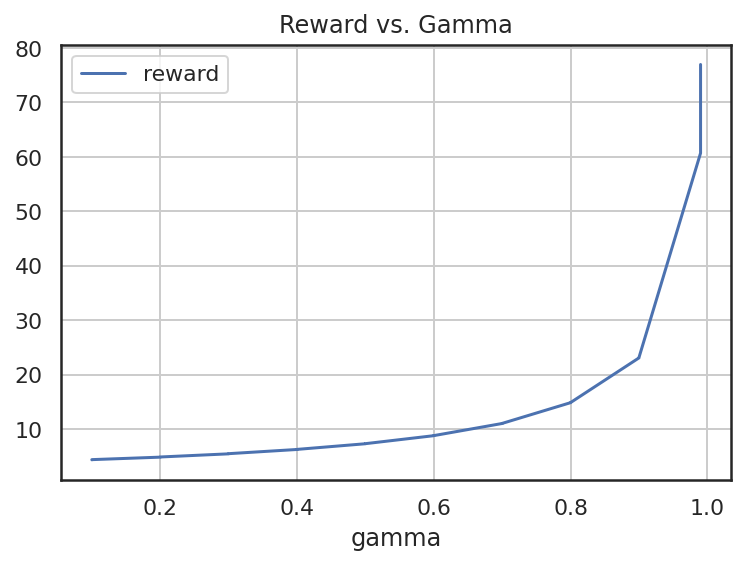

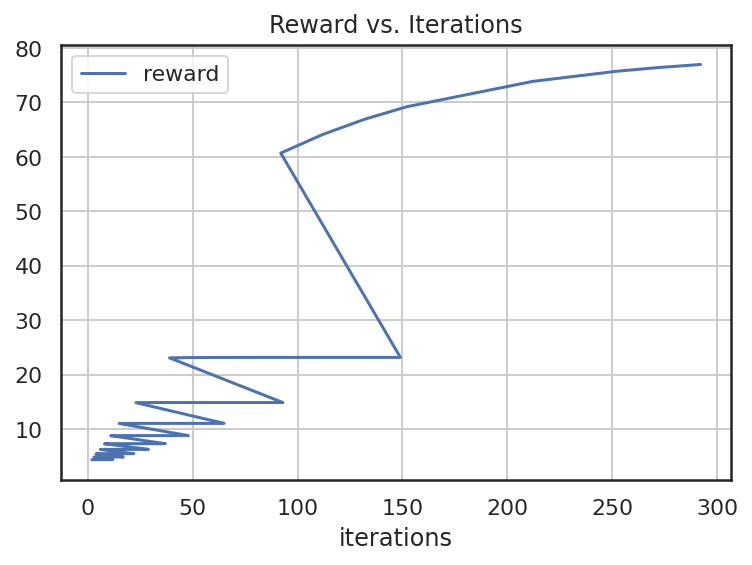

In [92]:
vi_res.plot(x='gamma', y='reward', title="Reward vs. Gamma")
plt.grid()

vi_res.plot(x='iterations', y='reward', title="Reward vs. Iterations")
plt.grid(True)

## Results

Best Result:
	Reward = 76.97
	Gamma = 0.9900000
	Epsilon= 1E-12


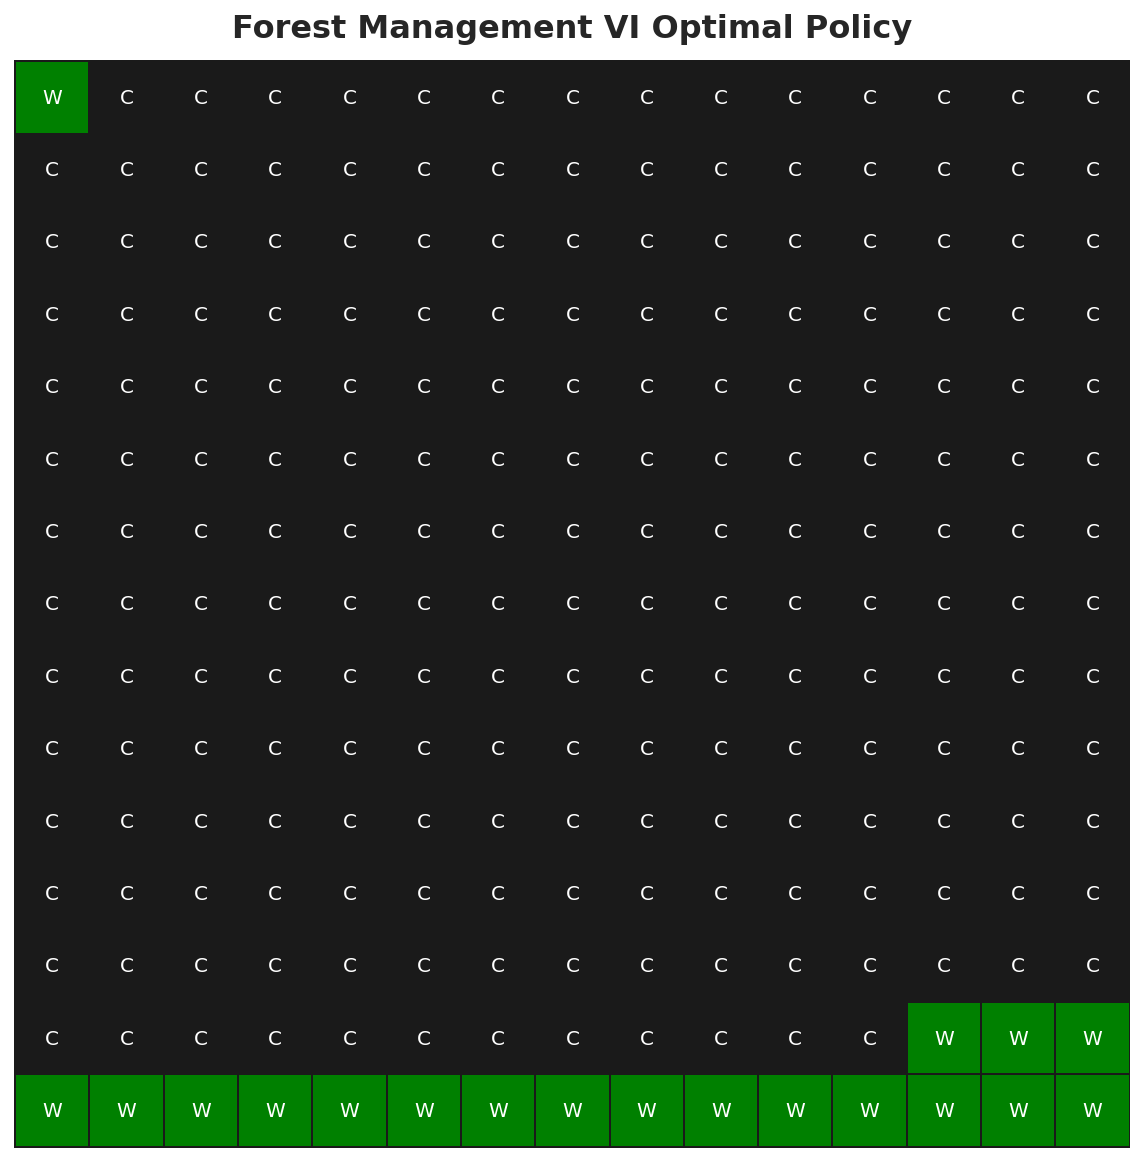

In [69]:
bestPolicy = vi_res['policy'][vi_res['reward'].argmax()]
plot_forest(bestPolicy, title='Forest Management VI Optimal Policy')

# Policy Iteration

In [88]:
def policyIteration(t, r, gammas, show_results=False, max_iterations=100000):
    t_start = time.time()
    
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    df = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        df['gamma'][testnum]        = g
        df['time'][testnum]         = Time
        df['iterations'][testnum]   = iters
        df['reward'][testnum]       = maxr
        df['mean_rewards'][testnum] = {tuple(mean_rewards)}
        df['max_rewards'][testnum]  = {tuple(max_rewards)}
        df['error'][testnum]        = np.mean(errors)
        df['policy'][testnum]       = {test.policy}
                
        if show_results:
            plot_forest(policy, title)
            pass
        
        testnum += 1
        
    endTime = time.time() - t_start
    
    policies = df['policy']
        
    # replace all nan's
    df.fillna(0, inplace=True)
    df.head()
        
    return df

In [71]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]
pi_res  = policyIteration(T, R, gammas, show_results=False)

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.01,	1,	4.396613
0.20,	0.00,	1,	4.882699
0.30,	0.00,	2,	5.491933
0.40,	0.00,	2,	6.277574
0.50,	0.02,	3,	7.329154
0.60,	0.02,	3,	8.809994
0.70,	0.01,	5,	11.054551
0.80,	0.02,	6,	14.883721
0.90,	0.03,	10,	23.172434
1.00,	0.06,	20,	508.385877
Time taken: 0.22


## Plots

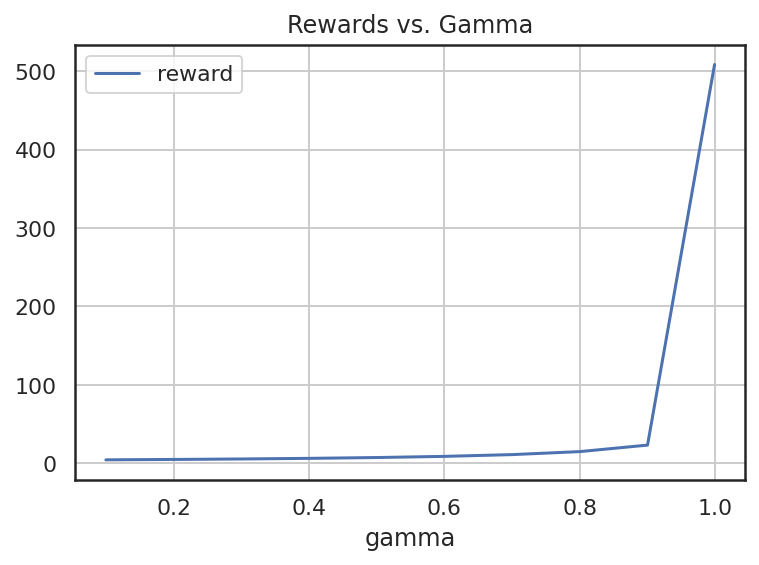

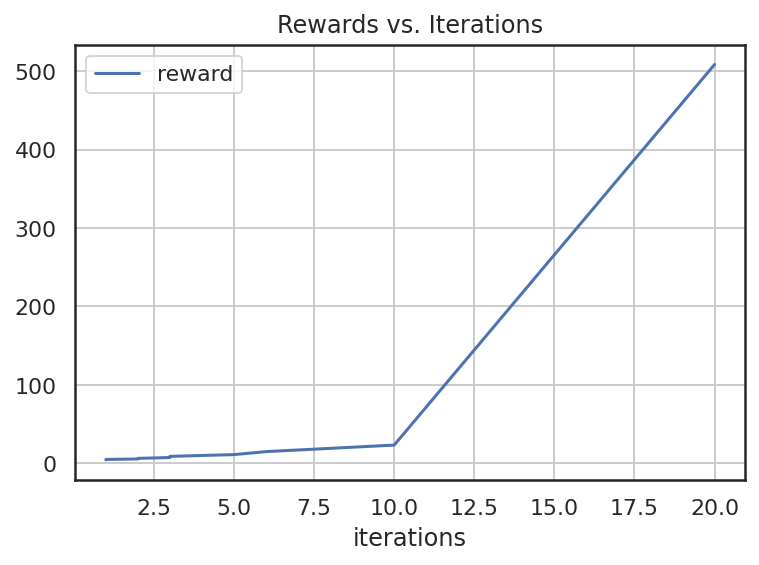

In [72]:
pi_res.plot(x='gamma', y='reward', title='Rewards vs. Gamma')
plt.grid()

pi_res.plot(x='iterations', y='reward', title='Rewards vs. Iterations')
plt.grid()

## Results

Best Result:
	Reward = 508.39
	Gamma = 0.999


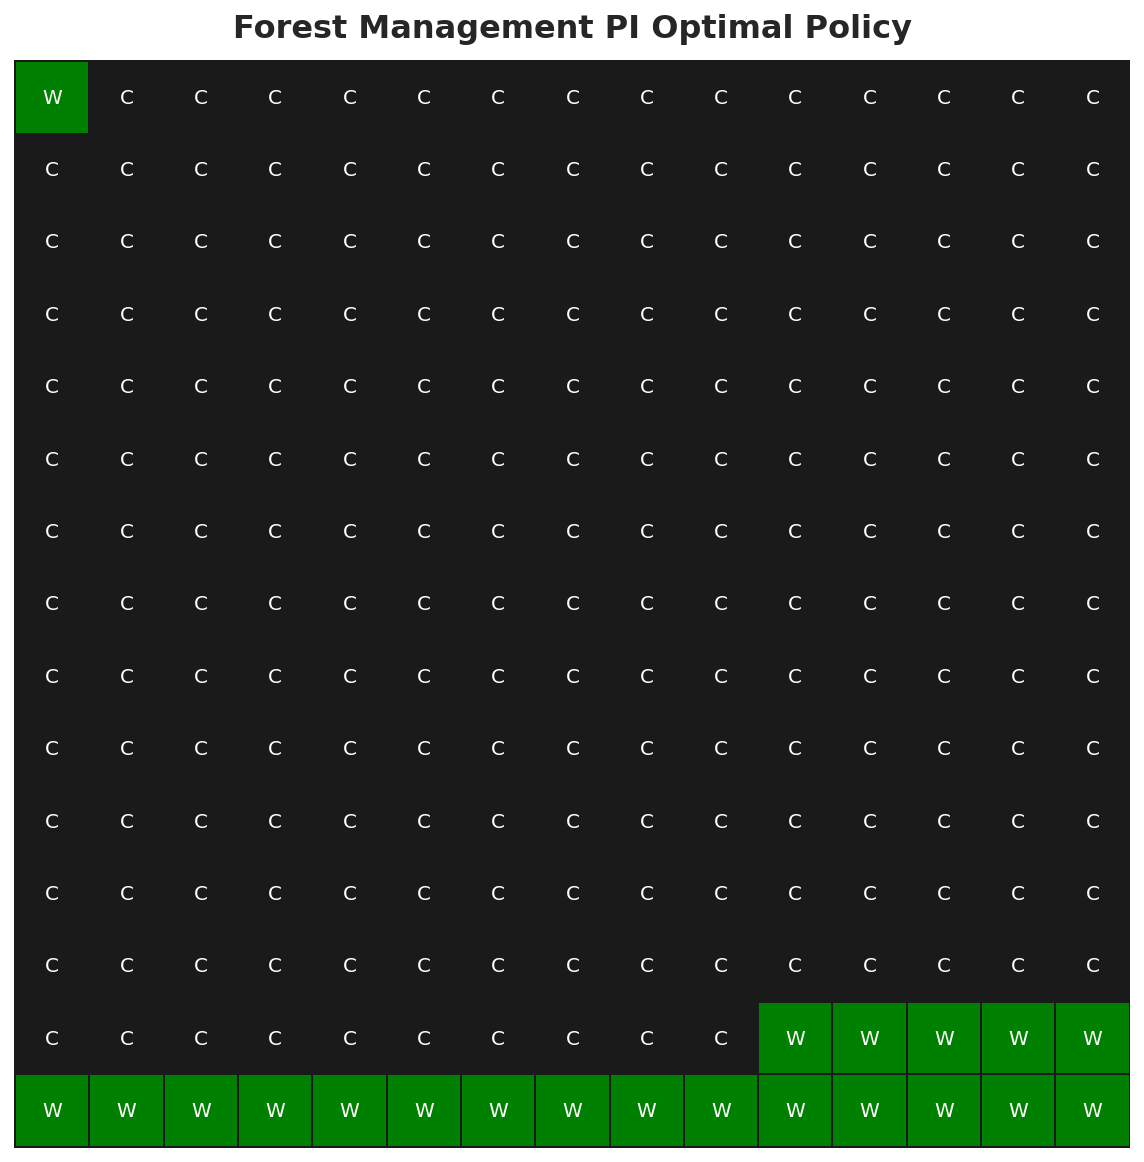

In [73]:
bestPolicy = pi_res['policy'][pi_res['reward'].argmax()]

plot_forest(bestPolicy, title='Forest Management PI Optimal Policy')

# Q-Learning

In [74]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], show_results=False):
    numTests = len(alphas)*len(gammas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    df = pd.DataFrame(0.0, index=np.arange(numTests), columns=['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error'])

    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
         
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        
                        df['gamma'][testNum]         = g
                        df['alpha'][testNum]         = a
                        df['alpha_decay'][testNum]   = a_decay
                        df['epsilon_decay'][testNum] = e_decay
                        df['time'][testNum]          = time
                        df['iterations'][testNum]    = iters
                        df['reward'][testNum]        = maxR
                        df['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        df['max_rewards'][testNum]   = {tuple(max_rewards)}
                        df['error'][testNum]         = np.mean(errors)
                        df['policy'][testNum]        = {test.policy}
                        
                        
                        if show_results:
                            pass
                        
                        testNum = testNum + 1
            
    policies = df['policy']
    
    df = df.fillna(0)
    df.head()
        
    return df

## Setup

In [75]:
gammas, alphas= [0.8, 0.9, 0.99], [0.01, 0.1, 0.2]
alpha_decays, epsilon_decays   = [0.9, 0.999], [0.9, 0.999]
iterations = [10000, 20000]

ql_res  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, show_results=False)

ql_res.head()

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000
0.80,	0.01,	0.76,	10000,	1.658158
Test Num 2/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:20000
0.80,	0.01,	1.39,	20000,	2.256950
Test Num 3/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000
0.80,	0.01,	0.76,	10000,	1.641186
Test Num 4/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:20000
0.80,	0.01,	1.40,	20000,	2.238910
Test Num 5/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:10000
0.80,	0.01,	0.76,	10000,	2.038321
Test Num 6/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:20000
0.80,	0.01,	1.40,	20000,	2.436602
Test Num 7/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000
0.8

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.8,0.01,0.900,0.900,10000.0,0.760584,1.658158,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{(4.4444444444444447e-05, 4.4444444444444447e-...","{(0.01, 0.01, 0.01, 0.01, 0.014608103849112963...","{(0.01, 0.0, 0.008100000000000001, 4.723920000..."
1,0.8,0.01,0.900,0.900,20000.0,1.389442,2.256950,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","{(4e-05, 4e-05, 6.624400000000001e-05, 6.62440...","{(0.009000000000000001, 0.009000000000000001, ...","{(0.009000000000000001, 0.0, 0.005904900000000..."
2,0.8,0.01,0.900,0.999,10000.0,0.759498,1.641186,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","{(4.4444444444444447e-05, 4.4444444444444447e-...","{(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0....","{(0.01, 0.0, 0.0, 0.0, 0.006561000000000002, 0..."
3,0.8,0.01,0.900,0.999,20000.0,1.395633,2.238910,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","{(0.0, 0.0, 0.0, 2.361960000000001e-05, 2.3619...","{(0.0, 0.0, 0.0, 0.005314410000000002, 0.00531...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020479..."
4,0.8,0.01,0.999,0.900,10000.0,0.757252,2.038321,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","{(4.4444444444444447e-05, 4.4444444444444447e-...","{(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0....","{(0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


## Policy

Best Result:
	Reward = 29.67
	Gamma = 0.99,
	Alpha = 0.20,
	Alpha Decay: 0.999,
	Epsilon Decay: 0.900,
	Iterations: 2.0E+04


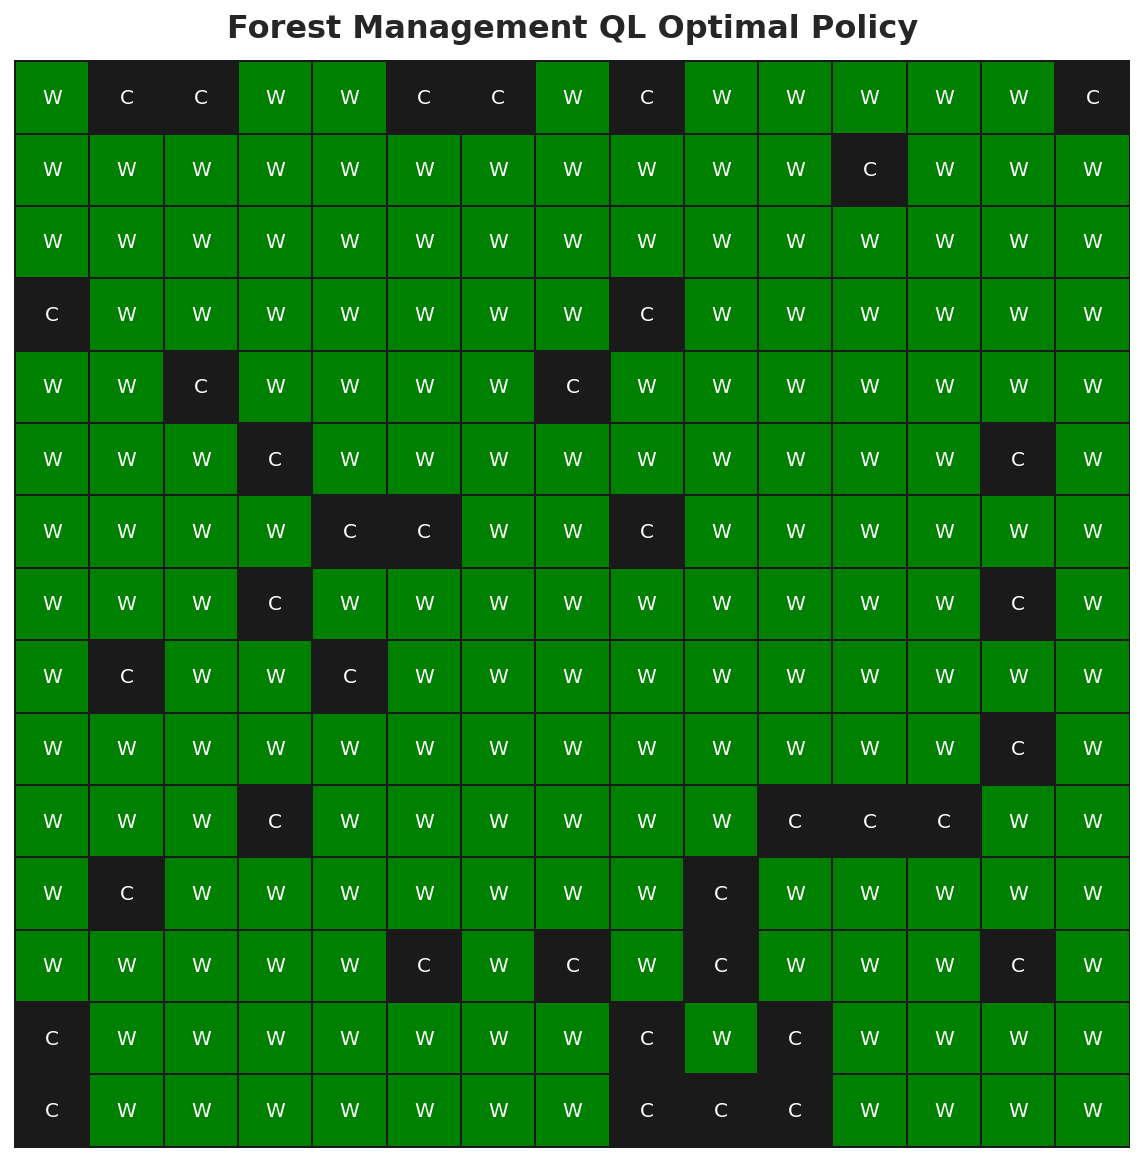

In [93]:
best_policy = ql_res['policy'][ql_res['reward'].argmax()]

best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(15, 15)

title='Forest Management QL Optimal Policy'
plot_forest(best_policy, title)

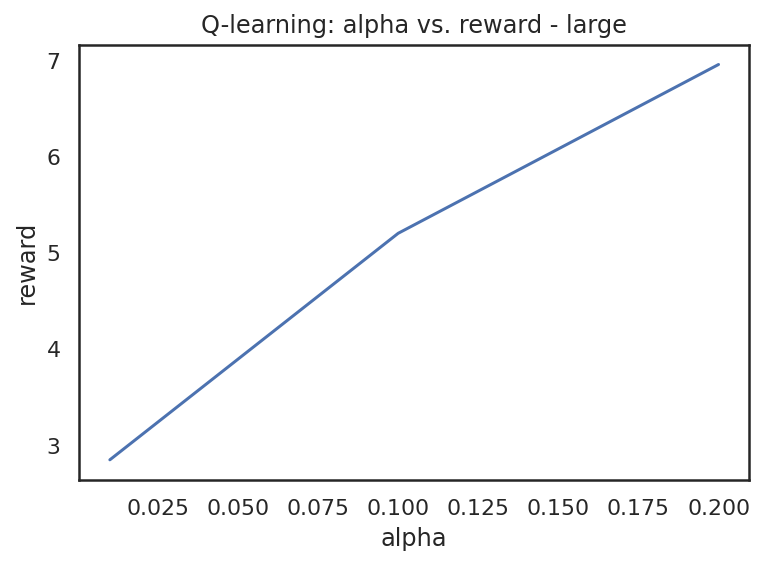

In [95]:
ql_res.groupby('alpha')['reward'].mean().plot()
plt.title('Q-learning: alpha vs. reward - large')
plt.ylabel('reward');

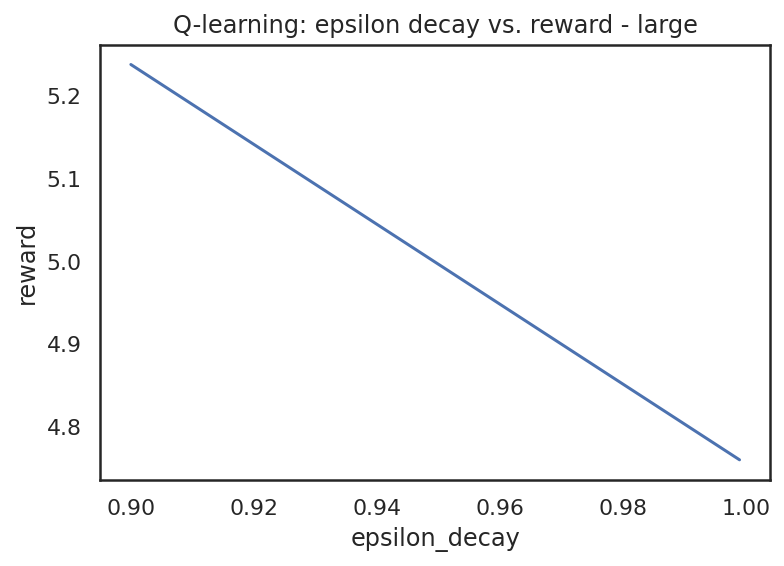

In [96]:
ql_res.groupby('epsilon_decay')['reward'].mean().plot()
plt.title('Q-learning: epsilon decay vs. reward - large')
plt.ylabel('reward');

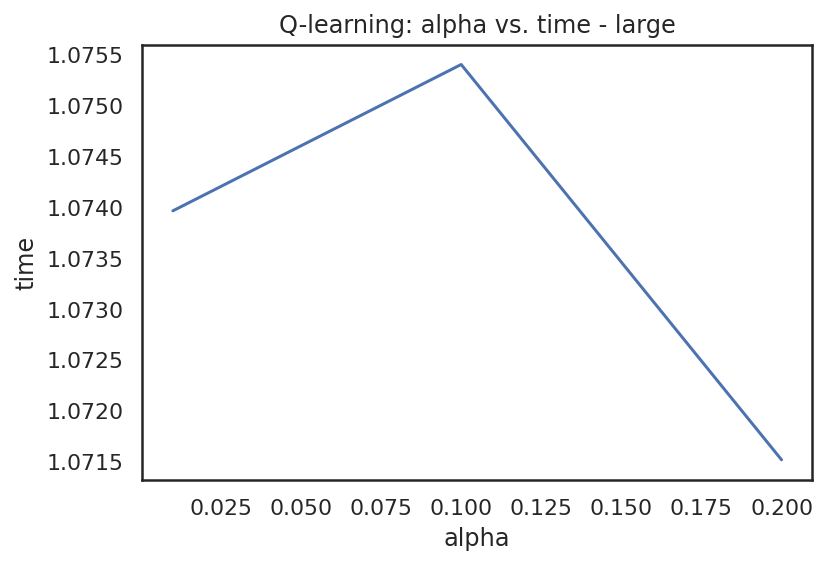

In [97]:
ql_res.groupby('alpha')['time'].mean().plot()
plt.title('Q-learning: alpha vs. time - large')
plt.ylabel('time');

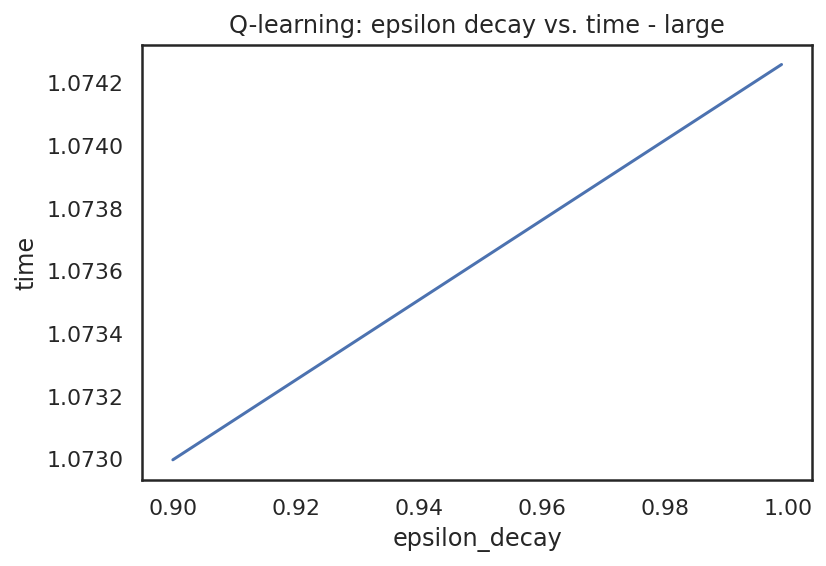

In [99]:
ql_res.groupby('epsilon_decay')['time'].mean().plot()
plt.title('Q-learning: epsilon decay vs. time - large')
plt.ylabel('time');